In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, make_scorer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path
import json

In [16]:
# read data
X_train = pd.read_csv('data/X_train.csv')
X_val   = pd.read_csv('data/X_val.csv')
X_test  = pd.read_csv('data/X_test.csv')

y_train = pd.read_csv('data/y_train.csv')
y_val   = pd.read_csv('data/y_val.csv')
y_test  = pd.read_csv('data/y_test.csv')

# check data
print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  " y_test :", y_test.shape)


y_train = y_train.astype(int)
y_val   = y_val.astype(int)
y_test  = y_test.astype(int)




Shapes:
  X_train: (766956, 74)  y_train: (766956, 1)
  X_val  : (328696, 74)  y_val  : (328696, 1)
  X_test : (273914, 74)  y_test : (273914, 1)


Data Preprocessing

step 1: encoding  

step2 : SMOTE 

step3:LDA 

step 4: high correlation 

step5:run model

In [17]:
# 1 encoding

# check object columns in the training set
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
# Display the first five rows of the application features
print("First five rows of application features:")
print(X_train.loc[:, categorical_cols].head())

# calculate the number of categories in each categorical column
num_categories = X_train[categorical_cols].nunique()
print("Number of categories in each categorical column:")
print(num_categories)


Categorical columns: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
First five rows of application features:
         term grade sub_grade emp_length home_ownership verification_status  \
0   36 months     B        B2  10+ years       MORTGAGE            Verified   
1   36 months     B        B3        NaN       MORTGAGE            Verified   
2   36 months     A        A5  10+ years            OWN        Not Verified   
3   36 months     B        B1    4 years       MORTGAGE        Not Verified   
4   36 months     D        D4   < 1 year           RENT            Verified   

    issue_d             purpose zip_code addr_state earliest_cr_line  \
0  Aug-2013  debt_consolidation    983xx         WA         Jan-1992   
1  Jan-2015  debt_consolidation    496xx         MI       

Feature Encoding Strategy

Ordinal Encoding (Ordered Categories → Numeric)
- `term`  
- `grade`  
- `sub_grade`  
- `emp_length`  

Date → Numeric Features (Derived Time Features)
- `issue_d` → Year/Month  
- `earliest_cr_line` → Credit account age (in months)  

One-Hot Encoding (Unordered & Low Cardinality ≤20)
- `home_ownership`  
- `verification_status`  
- `purpose`  
 


Target Encoding (Unordered & High Cardinality >20)
- `zip_code`  
- `addr_state` 

Binary Mapping (0/1)
- `hardship_flag` → `is_hardship`  
- `debt_settlement_flag` → `is_debt_settlement`  
- `disbursement_method` 0 :cash  1 :DirectPay
- `application_type`  0:Individual 1: Joint App
- `initial_list_status`  0:'f', 1:'w'

In [18]:
# original categorical columns
# term: "36 months" -> 36，"60 months" -> 60
X_train['term'] = X_train['term'].str.extract('(\d+)').astype(float)
X_val['term'] = X_val['term'].str.extract('(\d+)').astype(float)
X_test['term'] = X_test['term'].str.extract('(\d+)').astype(float)

# grade: transfer to integer
def convert_grade(x):
    if pd.isnull(x):
        return np.nan
    return ord(x) - ord('A') + 1  # A -> 1, B -> 2, ..., G -> 7
X_train['grade'] = X_train['grade'].apply(convert_grade)
X_val['grade'] = X_val['grade'].apply(convert_grade)
X_test['grade'] = X_test['grade'].apply(convert_grade)

# sub_grade: transfer to integer
def convert_sub_grade(x):
    if pd.isnull(x):
        return np.nan
    return ord(x[0]) - (ord('A') + 1)* 10 + (ord(x[1]) - ord('1'))   # A1 -> 11, B2 -> 22, ..., G5 -> 75

X_train['sub_grade'] = X_train['sub_grade'].apply(convert_sub_grade)
X_val['sub_grade'] = X_val['sub_grade'].apply(convert_sub_grade)
X_test['sub_grade'] = X_test['sub_grade'].apply(convert_sub_grade)

# emp_length: transfer to integer（< 1 year -> 0, 10+ years -> 10）
def convert_emp_length(x):
    if pd.isnull(x):
        return np.nan
    if '<' in x:
        return 0
    if '10+' in x:
        return 10
    return int(x.strip().split()[0])

X_train['emp_length'] = X_train['emp_length'].apply(convert_emp_length)
X_val['emp_length'] = X_val['emp_length'].apply(convert_emp_length)
X_test['emp_length'] = X_test['emp_length'].apply(convert_emp_length)


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/347184937.py:3: SyntaxWarning: invalid escape sequence '\d'
  X_train['term'] = X_train['term'].str.extract('(\d+)').astype(float)
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/347184937.py:4: SyntaxWarning: invalid escape sequence '\d'
  X_val['term'] = X_val['term'].str.extract('(\d+)').astype(float)
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/347184937.py:5: SyntaxWarning: invalid escape sequence '\d'
  X_test['term'] = X_test['term'].str.extract('(\d+)').astype(float)


In [19]:
# datatime columns dealing
def convert_datetime_to_numeric(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
    df[datetime_col + '_year'] = df[datetime_col].dt.year
    df[datetime_col + '_month'] = df[datetime_col].dt.month
    df = df.drop(columns=[datetime_col])
    return df

X_train = convert_datetime_to_numeric(X_train, 'earliest_cr_line')
X_train = convert_datetime_to_numeric(X_train, 'issue_d')
X_val = convert_datetime_to_numeric(X_val, 'earliest_cr_line')
X_val = convert_datetime_to_numeric(X_val, 'issue_d')
X_test = convert_datetime_to_numeric(X_test, 'earliest_cr_line')
X_test = convert_datetime_to_numeric(X_test, 'issue_d')

/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/2354524526.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/2354524526.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
/var/folders/xg/6886p3rj5kb44k2smttjctf80000gn/T/ipykernel_3211/2354524526.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col], errors='c

In [20]:
# one-hot encoding for categorical columns
col_list = ['home_ownership', 'verification_status', 'purpose']

# 1) Fill missing values with 'Missing'
X_train[col_list] = X_train[col_list].fillna('Missing')
X_val[col_list]   = X_val[col_list].fillna('Missing')
X_test[col_list]  = X_test[col_list].fillna('Missing')

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
ohe.fit(X_train[col_list])

def apply_ohe(df, cols, encoder):
    arr = encoder.transform(df[cols])
    feat_names = encoder.get_feature_names_out(cols)
    enc_df = pd.DataFrame(arr, columns=feat_names, index=df.index)
    return pd.concat([df.drop(columns=cols), enc_df], axis=1)

X_train = apply_ohe(X_train, col_list, ohe)
X_val   = apply_ohe(X_val,   col_list, ohe)
X_test  = apply_ohe(X_test,  col_list, ohe)


In [21]:
# target encoding

for df in (X_train, X_val, X_test):
    df['zip_code'] = df['zip_code'].str[:3].fillna('Missing').astype(str)

te_zip = ce.TargetEncoder(cols=['zip_code'], min_samples_leaf=50, smoothing=20)
te_zip.fit(X_train[['zip_code']], y_train)

for df in (X_train, X_val, X_test):
    df['zip_code'] = te_zip.transform(df[['zip_code']])['zip_code']

# addr_state =
te_state = ce.TargetEncoder(cols=['addr_state'], min_samples_leaf=50, smoothing=20)
te_state.fit(X_train[['addr_state']], y_train)
for df in (X_train, X_val, X_test):
    df['addr_state'] = te_state.transform(df[['addr_state']])['addr_state']


In [22]:
# binary columns coding

# initial_list_status : convert to integer (e.g., 'f' -> 0, 'w' -> 1)
def convert_initial_list_status(x):
    if x == 'f':
        return 0
    elif x == 'w':
        return 1

# application_type : convert to integer (e.g., 'Individual' -> 0, 'Joint App' -> 1)
def convert_application_type(x):
    if x == 'Individual':
        return 0
    elif x == 'Joint App':
        return 1


def convert_hardship_debt_flag(x):
    if x == 'N':
        return 0
    elif x == 'Y':
        return 1


def convert_disbursement_method(x):
    if x == 'Cash':
        return 0
    elif x == 'DirectPay':
        return 1



for df in (X_train, X_val, X_test):
    df['initial_list_status'] = df['initial_list_status'].apply(convert_initial_list_status)
    df['application_type'] = df['application_type'].apply(convert_application_type)
    df['hardship_flag'] = df['hardship_flag'].apply(convert_hardship_debt_flag)
    df['disbursement_method'] = df['disbursement_method'].apply(convert_disbursement_method)
    df['debt_settlement_flag'] = df['debt_settlement_flag'].apply(convert_hardship_debt_flag)



In [23]:
# check for NaN values in application features
print("Checking for NaN values in application features:")
print(X_train.isnull().sum().sort_values(ascending=False))

Checking for NaN values in application features:
il_util                 496507
all_util                454345
total_cu_tl             454315
inq_last_12m            454315
total_bal_il            454314
                         ...  
disbursement_method          0
debt_settlement_flag         0
issue_d_year                 0
issue_d_month                0
purpose_wedding              0
Length: 96, dtype: int64


In [24]:
# impute missing values
# deal with missing values ,# using median for numerical columns
imputer = SimpleImputer(strategy='median')
for df in (X_train, X_val, X_test):
    # Fill missing values for categorical columns with 'Missing'
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df[num_cols] = imputer.fit_transform(df[num_cols])

SMOTE

In [25]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE resampling results:")
print(y_train_resampled.value_counts())

SMOTE resampling results:
default
0          604093
1          604093
Name: count, dtype: int64


standardscale

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [27]:
# using Linear Discriminant Analysis (LDA) for dimensionality reduction
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_resampled)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)

lda_df = pd.DataFrame(X_train_lda, columns=['LD1'])
lda_df['default'] = y_train_resampled
print(f"X_train_lda: {X_train_lda.shape}, X_val_lda: {X_val_lda.shape}, X_test_lda: {X_test_lda.shape}")



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train_lda: (1208186, 1), X_val_lda: (328696, 1), X_test_lda: (273914, 1)


LDA

In [28]:


feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature_{i}' for i in range(X_train.shape[1])]

lda_coeff_df = pd.DataFrame(
    np.abs(lda.scalings_), 
    index=feature_names,
    columns=[f'LD{i+1}' for i in range(lda.scalings_.shape[1])]
)

lda_coeff_df['Total_Contribution'] = lda_coeff_df.sum(axis=1)
top_features = lda_coeff_df.sort_values(by='Total_Contribution', ascending=False).head(30)
print("Top 30 features based on LDA coefficients:")
print(top_features)

selected_features = top_features.index.tolist()
print("Selected features for the final model:", selected_features)


Top 30 features based on LDA coefficients:
                                  LD1  Total_Contribution
fico_range_low              14.224096           14.224096
fico_range_high             14.111776           14.111776
debt_settlement_flag         0.590723            0.590723
term                         0.337944            0.337944
grade                        0.266604            0.266604
issue_d_year                 0.227215            0.227215
open_acc                     0.217446            0.217446
num_sats                     0.192083            0.192083
zip_code                     0.160795            0.160795
acc_open_past_24mths         0.158591            0.158591
total_bc_limit               0.145981            0.145981
earliest_cr_line_year        0.132433            0.132433
installment                  0.130784            0.130784
mo_sin_old_rev_tl_op         0.120583            0.120583
num_rev_accts                0.112381            0.112381
dti                          

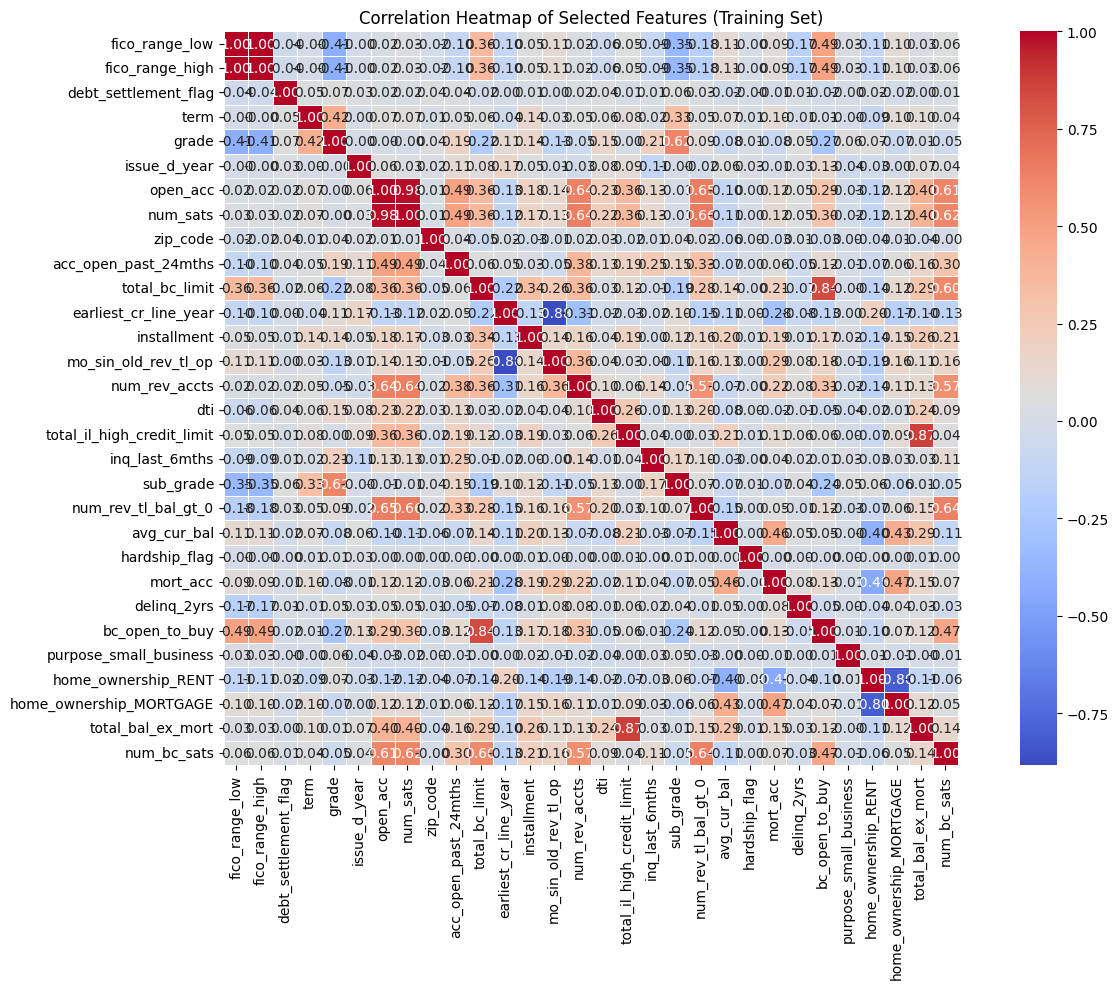

In [29]:
# correlation heatmap, delete the features highly correlated with each other
X_corr = pd.DataFrame(X_train, columns=selected_features)

correlation_matrix = X_corr.corr(method='pearson')
# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Correlation Heatmap of Selected Features (Training Set)")
plt.tight_layout()
plt.show()

In [30]:
# find highly correlated features
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if abs(upper.loc[row, col]) > 0.85]

for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} vs {f2} --> correlation = {corr_val:.2f}")

fico_range_high vs fico_range_low --> correlation = 1.00
num_sats vs open_acc --> correlation = 0.98
mo_sin_old_rev_tl_op vs earliest_cr_line_year --> correlation = -0.88
total_bal_ex_mort vs total_il_high_credit_limit --> correlation = 0.87


In [31]:
# drop highly correlated features
columns_to_drop = [
    'fico_range_high',
    'open_acc',
    'earliest_cr_line_year',
    'total_il_high_credit_limit'
]
final_features = [f for f in selected_features if f not in columns_to_drop]
print("Removed due to high correlation:", columns_to_drop)
print("Remaining features for model:", final_features)

Removed due to high correlation: ['fico_range_high', 'open_acc', 'earliest_cr_line_year', 'total_il_high_credit_limit']
Remaining features for model: ['fico_range_low', 'debt_settlement_flag', 'term', 'grade', 'issue_d_year', 'num_sats', 'zip_code', 'acc_open_past_24mths', 'total_bc_limit', 'installment', 'mo_sin_old_rev_tl_op', 'num_rev_accts', 'dti', 'inq_last_6mths', 'sub_grade', 'num_rev_tl_bal_gt_0', 'avg_cur_bal', 'hardship_flag', 'mort_acc', 'delinq_2yrs', 'bc_open_to_buy', 'purpose_small_business', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'total_bal_ex_mort', 'num_bc_sats']


standard

In [33]:
# rescale the final features after feature selection
# 1. 先做特征删除（列筛选）
X_train_reduced = X_train[final_features]  
X_val_reduced   = X_val[final_features]
X_test_reduced  = X_test[final_features]

# 2. 然后再标准化
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_val_scaled   = scaler.transform(X_val_reduced)
X_test_scaled  = scaler.transform(X_test_reduced)

# 3. 给标准化后的数据加回正确的列名（因为现在维度对得上了）
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=final_features)
X_val_scaled_df   = pd.DataFrame(X_val_scaled, columns=final_features)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=final_features)



In [34]:
Xtr = np.asarray(X_train_scaled)
Xva = np.asarray(X_val_scaled)
Xte = np.asarray(X_test_scaled)

ytr = np.asarray(y_train).astype(int)
yva = np.asarray(y_val).astype(int)
yte = np.asarray(y_test).astype(int)

Xtrval = np.vstack([Xtr, Xva])
ytrval = np.concatenate([ytr, yva])



# model training

In [40]:

RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Function to get the predicted probabilities for the positive class
def pos_proba(model, X):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        if p.ndim == 2 and p.shape[1] == 2: return p[:,1]
        if p.ndim == 2 and p.shape[1] == 1: return p[:,0]
        if p.ndim == 1: return p
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    return model.predict(X).astype(float)

def compute_metrics(y_true, y_score, y_pred):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1-Score":  f1_score(y_true, y_pred, zero_division=0),
        "AUC-ROC":   roc_auc_score(y_true, y_score),
    }

 # Training  based on train set with 5-fold CV (using AUC for hyperparameter tuning), then evaluate on validation set
def stratified_subset(X, y, frac=0.01, cv_splits=5, random_state=42):
    classes, counts = np.unique(y, return_counts=True)
    min_frac_needed = max(cv_splits / counts)  # ensure each class is represented in each fold
    frac = min(1.0, max(frac, float(min_frac_needed) + 1e-6))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=random_state)
    idx, _ = next(sss.split(X, y))
    return X[idx], y[idx]

# Function to perform hyperparameter tuning using GridSearchCV
def stratified_take(X, y, frac=0.10, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=random_state)
    idx, _ = next(sss.split(X, y))
    return X[idx], y[idx]

# Function to find the best threshold for classification based on F1 score or other metrics
def find_best_threshold(y_true, y_score, mode="f1", min_precision=None, min_recall=None, step=0.01):
    best_t, best_val = 0.5, -1
    grid = np.arange(step, 1.0, step)
    for t in grid:
        y_pred = (y_score >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if mode == "f1":
            val = f1
            if (min_precision is not None and p < min_precision) or (min_recall is not None and r < min_recall):
                continue
        elif mode == "recall_at_precision":
            if min_precision is None: raise ValueError("need min_precision")
            val = r if p >= min_precision else -1
        elif mode == "precision_at_recall":
            if min_recall is None: raise ValueError("need min_recall")
            val = p if r >= min_recall else -1
        else:
            raise ValueError("Unknown mode")
        if val > best_val:
            best_val, best_t = val, float(t)
    return best_t, best_val

# Function to evaluate the model at a specific threshold
def metrics_at_threshold(y_true, y_score, t):
    y_pred = (y_score >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    # Type I / II （default as 1）
    type1_err_rate = fp / (fp + tn + 1e-12)   # FPR
    type2_err_rate = fn / (tp + fn + 1e-12)   # FNR
    
    return dict(
        Accuracy  = float(accuracy_score(y_true, y_pred)),
        Precision = float(precision_score(y_true, y_pred, zero_division=0)),
        Recall    = float(recall_score(y_true, y_pred, zero_division=0)),
        F1_Score  = float(f1_score(y_true, y_pred, zero_division=0)),
        AUC_ROC   = float(roc_auc_score(y_true, y_score)),
        Threshold = float(t),

        TN = int(tn), FP = int(fp), FN = int(fn), TP = int(tp),
        Type1_Error_Rate = float(type1_err_rate),  # = FPR
        Type2_Error_Rate = float(type2_err_rate),  # = FNR
    )



In [49]:
def models_catalog():
    models = {
        "Logistic Regression": (
            LogisticRegression(max_iter=2000, solver='lbfgs', random_state=RANDOM_STATE),
            {"C":[0.5,1.0,2.0], "class_weight":[None,"balanced"]}
        ),
        "Decision Tree": (
            DecisionTreeClassifier(random_state=RANDOM_STATE),
            {"max_depth":[3,5,8,None], "min_samples_leaf":[1,5,20], "class_weight":[None,"balanced"]}
        ),
        "Random Forest": (
            RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
            {"n_estimators": [100,100,100], "max_depth":[None,8,12], "min_samples_leaf":[1,5,20], "max_features":["sqrt","log2"], "class_weight":[None,"balanced"]}
        ),
        "SVM": (
            SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE),
            {"C":[0.5,1.0,3.0], "gamma":["scale"], "class_weight":[None,"balanced"]}
        ),
        "Neural Network": (
            MLPClassifier(max_iter=300, early_stopping=True, random_state=RANDOM_STATE),
            {"hidden_layer_sizes":[(64,),(128,),(64,32)], "alpha":[1e-4,1e-3], "learning_rate_init":[1e-3]}
        ),
        "XGBoost" : (
            XGBClassifier(random_state=RANDOM_STATE, eval_metric="auc", tree_method="hist", n_jobs=-1, use_label_encoder=False),
            {"n_estimators":[200,500], "max_depth":[3,5], "learning_rate":[0.05,0.1], "subsample":[0.8,1.0], "colsample_bytree":[0.8,1.0]}
        )
    }
    return models

In [45]:
def run_one_model(name, base_est, param_grid,
                  Xtr, ytr, Xva, yva, Xte, yte,
                  cv, refit_on_trainval=True, svm_cv_frac=0.01,
                  out_dir="results",
                  # Threshold tuning (passed to run_one_model)
                  threshold_mode="f1",          # "f1" / "recall_at_precision" / "precision_at_recall"
                  min_precision=None,           # for "recall_at_precision"
                  min_recall=None,          # for "precision_at_recall"
                  step=0.01):

    """
    Train, tune, and evaluate a single model.
    Steps:
    1. (Optional) Use a smaller subset for SVM during CV to speed up training.
    2. Hyperparameter tuning with GridSearchCV (AUC as scoring).
    3. Find the optimal decision threshold on the validation set.
    4. Retrain the model on Train+Val with best parameters.
    5. Evaluate on test set using the tuned threshold.
    6. Save metrics (including Type I/II error) and ROC curve to files.
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # for SVM, we can use a smaller subset for hyperparameter tuning
    X_fit, y_fit = Xtr, ytr
    if name == "SVM" and svm_cv_frac is not None:
        X_fit, y_fit = stratified_subset(Xtr, ytr, frac=svm_cv_frac, cv_splits=cv.n_splits, random_state=RANDOM_STATE)
        print(f"[SVM] Using {len(y_fit)} samples (~{len(y_fit)/len(ytr):.2%}) for GridSearchCV")
    if name == "Random Forest":
        X_fit, y_fit = stratified_subset(Xtr, ytr, frac=0.10, cv_splits=cv.n_splits, random_state=RANDOM_STATE)

    # use GridSearchCV for hyperparameter tuning （ Using AUC-ROC as scoring metric）
    gs = GridSearchCV(base_est, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_fit, y_fit)
    best_params = gs.best_params_
    print(f"[{name}] CV best AUC={gs.best_score_:.4f}, params={best_params}")

    #  Threshold tuning on validation set
    est_val  = gs.best_estimator_
    va_score = pos_proba(est_val, Xva)
    
    #Find optimal threshold according to the given mode
    t_opt, _ = find_best_threshold(
        yva, va_score,
        mode=threshold_mode,
        min_precision=min_precision,
        min_recall=min_recall,
        step=step
    )
    val_metrics = metrics_at_threshold(yva, va_score, t_opt)   # tuned on validation

    # Metrics on validation set using tuned threshold
    if refit_on_trainval:
        Xtrval = np.vstack([Xtr, Xva]); ytrval = np.concatenate([ytr, yva])
        est_final = base_est.__class__(**{**base_est.get_params(), **best_params})
        if name == "Random Forest": 
            est_final.set_params(n_estimators=600)
            
        est_final.fit(Xtrval, ytrval)
    else:
        est_final = est_val
    #   Evaluate on test set using the tuned threshold
    te_score     = pos_proba(est_final, Xte)
    test_metrics = metrics_at_threshold(yte, te_score, t_opt)  # ONLY tuned threshold

    # Save result.json 
    out_json = Path(out_dir)/f"{name.replace(' ','_').lower()}_result.json"
    payload = {
        "model": name,
        "best_params": best_params,
        "cv_best_auc": float(gs.best_score_),
        "threshold_tuning": {
            "mode": threshold_mode,
            "min_precision": min_precision,
            "min_recall": min_recall,
            "step": step,
            "selected_threshold": float(t_opt),
        },
        "val_metrics":  val_metrics,   
        "test_metrics": test_metrics,  
    }
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

    # Save ROC curve (fpr, tpr) for plotting
    fpr, tpr, _ = roc_curve(yte, te_score)
    pd.DataFrame({"fpr":fpr, "tpr":tpr}).to_csv(Path(out_dir)/f"{name.replace(' ','_').lower()}_roc.csv", index=False)

    print(f"[{name}] Test AUC={test_metrics['AUC_ROC']:.4f} @ t={t_opt:.2f} | F1={test_metrics['F1_Score']:.4f} | "
          f"Type I={test_metrics['Type1_Error_Rate']:.3f}, Type II={test_metrics['Type2_Error_Rate']:.3f}")
    return payload, est_final

In [60]:
def run_selected(models_to_run, 
                 refit_on_trainval=True, 
                 out_dir="results",
                 svm_cv_frac=0.01,
                 # hreshold tuning (passed to run_one_model)
                 threshold_mode="f1",          # "f1" / "recall_at_precision" / "precision_at_recall"
                 min_precision=None, 
                 min_recall=None, 
                 step=0.01):
    """
    Train and evaluate multiple selected models, then generate/update the performance comparison table.
    - Table includes: Accuracy, Precision, Recall, F1-Score, AUC-ROC, Type I/II Err, Threshold, CV_AUC
    - If use_small=True, will take a stratified subset of train/val (and optionally test) to speed up training.
    """

    # data
    Xtr = np.asarray(X_train_scaled); Xva = np.asarray(X_val_scaled); Xte = np.asarray(X_test_scaled)
    ytr = np.asarray(y_train).astype(int); yva = np.asarray(y_val).astype(int); yte = np.asarray(y_test).astype(int)

   
    Xtr, ytr = stratified_subset(Xtr, ytr, frac=0.1, cv_splits=cv.n_splits, random_state=RANDOM_STATE)
    Xva, yva = stratified_take(Xva, yva, frac=0.1, random_state=RANDOM_STATE)
    
    
    #  Retrieve available models from catalog
    catalog = models_catalog()
    all_rows = []

    for name in models_to_run:
        if name not in catalog:
            continue
        base_est, param_grid = catalog[name]

        # Train a single model (CV → threshold tuning → optional retrain on Train+Val → test evaluation)
        res, _ = run_one_model(
            name, base_est, param_grid,
            Xtr, ytr, Xva, yva, Xte, yte,
            cv=cv, refit_on_trainval=refit_on_trainval, out_dir=out_dir,
            svm_cv_frac=svm_cv_frac,
            # # Threshold tuning params
            threshold_mode=threshold_mode,
            min_precision=min_precision,
            min_recall=min_recall,
            step=step
        )

        # 5. Collect performance metrics (only tuned-threshold test results)
        all_rows.append({
            "Model":      res["model"],
            "Accuracy":   res["test_metrics"]["Accuracy"],
            "Precision":  res["test_metrics"]["Precision"],
            "Recall":     res["test_metrics"]["Recall"],
            "F1-Score":   res["test_metrics"]["F1_Score"],
            "AUC-ROC":    res["test_metrics"]["AUC_ROC"],
            "Type I Err": res["test_metrics"]["Type1_Error_Rate"],  # FP/(FP+TN)
            "Type II Err":res["test_metrics"]["Type2_Error_Rate"],  # FN/(TP+FN)
            "Threshold":  res["threshold_tuning"]["selected_threshold"],
            "CV_AUC":     res["cv_best_auc"], # Best CV AUC during hyperparameter tuning
        })

    # save and update performance comparison table
    from pathlib import Path
    table_path = Path(out_dir) / "model_performance_comparison_test.csv"
    if table_path.exists():
        hist = pd.read_csv(table_path)
        keep = hist[~hist["Model"].isin([r["Model"] for r in all_rows])]
        perf_df = pd.concat([keep, pd.DataFrame(all_rows)], ignore_index=True)
    else:
        perf_df = pd.DataFrame(all_rows)

    order = ["Logistic Regression","Decision Tree","XGBoost","SVM","Random Forest","Neural Network"]
    perf_df["Model"] = pd.Categorical(perf_df["Model"], categories=order + sorted(set(perf_df["Model"]) - set(order)), ordered=True)
    perf_df = perf_df.sort_values("Model")

    cols = ["Model","Accuracy","Precision","Recall","F1-Score","AUC-ROC","Type I Err","Type II Err","Threshold","CV_AUC"]
    perf_df = perf_df[cols].round(4)

    perf_df.to_csv(table_path, index=False)
    print(f"\n✅ Model Performance Comparison saved to {table_path}")
    print(perf_df)

    return perf_df


In [38]:
# def run_selected(models_to_run, refit_on_trainval=True, out_dir="results"):
#     # 数据
#     Xtr = np.asarray(X_train_scaled); Xva = np.asarray(X_val_scaled); Xte = np.asarray(X_test_scaled)
#     ytr = np.asarray(y_train).astype(int); yva = np.asarray(y_val).astype(int); yte = np.asarray(y_test).astype(int)

#     catalog = models_catalog()
#     all_rows = []

#     for name in models_to_run:
#         base_est, param_grid = catalog[name]
#         res, _est = run_one_model(
#             name, base_est, param_grid,
#             Xtr, ytr, Xva, yva, Xte, yte,
#             cv=cv, refit_on_trainval=refit_on_trainval, out_dir=out_dir
#         )
#         row = {
#             "Model": name,
#             "Accuracy":  res["test_metrics"]["Accuracy"],
#             "Precision": res["test_metrics"]["Precision"],
#             "Recall":    res["test_metrics"]["Recall"],
#             "F1-Score":  res["test_metrics"]["F1-Score"],
#             "AUC-ROC":   res["test_metrics"]["AUC-ROC"],
#             "CV_AUC":    res["cv_best_auc"]
#         }
#         all_rows.append(row)

#     # 读取历史结果并合并（支持多次追加运行）
#     table_path = Path(out_dir)/"model_performance_comparison_test.csv"
#     if table_path.exists():
#         hist = pd.read_csv(table_path)
#         # 去重：新结果覆盖同名模型
#         keep = hist[~hist["Model"].isin([r["Model"] for r in all_rows])]
#         perf_df = pd.concat([keep, pd.DataFrame(all_rows)], ignore_index=True)
#     else:
#         perf_df = pd.DataFrame(all_rows)

#     # 排序并保存
#     order = ["Logistic Regression","Decision Tree","XGBoost","SVM","Random Forest","Neural Network"]
#     perf_df["Model"] = pd.Categorical(perf_df["Model"], categories=order, ordered=True)
#     perf_df = perf_df.sort_values("Model")
#     perf_df = perf_df[["Model","Accuracy","Precision","Recall","F1-Score","AUC-ROC","CV_AUC"]].round(4)
#     perf_df.to_csv(table_path, index=False)
#     print("\n===== Model Performance Comparison (Test) =====")
#     print(perf_df)

#     # 可选：合并 ROC（只合并当前跑的；画图时再读取）
#     return perf_df

In [61]:
run_selected(["Logistic Regression"])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[Logistic Regression] CV best AUC=0.7532, params={'C': 0.5, 'class_weight': 'balanced'}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Logistic Regression] Test AUC=0.7525 @ t=0.52 | F1=0.4809 | Type I=0.244, Type II=0.397

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532


In [62]:
run_selected(["Random Forest"])




/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

[Random Forest] CV best AUC=0.7501, params={'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Random Forest] Test AUC=0.7512 @ t=0.25 | F1=0.4778 | Type I=0.217, Type II=0.433

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   
1        Random Forest    0.7370     0.4131  0.5666    0.4778   0.7512   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  
1      0.2170       0.4334       0.25  0.7501  


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532
1,Random Forest,0.7370,0.4131,0.5666,0.4778,0.7512,0.2170,0.4334,0.25,0.7501


In [63]:
run_selected(["Decision Tree"])


[Decision Tree] CV best AUC=0.7355, params={'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 1}
[Decision Tree] Test AUC=0.7376 @ t=0.20 | F1=0.4634 | Type I=0.302, Type II=0.360

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   
2        Decision Tree    0.6855     0.3633  0.6395    0.4634   0.7376   
1        Random Forest    0.7370     0.4131  0.5666    0.4778   0.7512   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  
2      0.3021       0.3605       0.20  0.7355  
1      0.2170       0.4334       0.25  0.7501  


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532
2,Decision Tree,0.6855,0.3633,0.6395,0.4634,0.7376,0.3021,0.3605,0.20,0.7355
1,Random Forest,0.7370,0.4131,0.5666,0.4778,0.7512,0.2170,0.4334,0.25,0.7501


In [64]:
run_selected(["Neural Network"])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vecto

[Neural Network] CV best AUC=0.7551, params={'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Neural Network] Test AUC=0.7569 @ t=0.25 | F1=0.4830 | Type I=0.203, Type II=0.442

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   
1        Decision Tree    0.6855     0.3633  0.6395    0.4634   0.7376   
2        Random Forest    0.7370     0.4131  0.5666    0.4778   0.7512   
3       Neural Network    0.7463     0.4258  0.5581    0.4830   0.7569   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  
1      0.3021       0.3605       0.20  0.7355  
2      0.2170       0.4334       0.25  0.7501  
3      0.2029       0.4419       0.25  0.7551  


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532
1,Decision Tree,0.6855,0.3633,0.6395,0.4634,0.7376,0.3021,0.3605,0.20,0.7355
2,Random Forest,0.7370,0.4131,0.5666,0.4778,0.7512,0.2170,0.4334,0.25,0.7501
3,Neural Network,0.7463,0.4258,0.5581,0.4830,0.7569,0.2029,0.4419,0.25,0.7551


In [65]:
run_selected(["XGBoost"])


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[XGBoost] CV best AUC=0.7605, params={'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:50:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost] Test AUC=0.7599 @ t=0.24 | F1=0.4864 | Type I=0.234, Type II=0.399

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   
1        Decision Tree    0.6855     0.3633  0.6395    0.4634   0.7376   
4              XGBoost    0.7306     0.4086  0.6007    0.4864   0.7599   
2        Random Forest    0.7370     0.4131  0.5666    0.4778   0.7512   
3       Neural Network    0.7463     0.4258  0.5581    0.4830   0.7569   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  
1      0.3021       0.3605       0.20  0.7355  
4      0.2344       0.3993       0.24  0.7605  
2      0.2170       0.4334       0.25  0.7501  
3      0.2029       0.4419       0.25  0.7551  


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532
1,Decision Tree,0.6855,0.3633,0.6395,0.4634,0.7376,0.3021,0.3605,0.20,0.7355
4,XGBoost,0.7306,0.4086,0.6007,0.4864,0.7599,0.2344,0.3993,0.24,0.7605
2,Random Forest,0.7370,0.4131,0.5666,0.4778,0.7512,0.2170,0.4334,0.25,0.7501
3,Neural Network,0.7463,0.4258,0.5581,0.4830,0.7569,0.2029,0.4419,0.25,0.7551


In [66]:
run_selected(["SVM"])


[SVM] Using 766 samples (~1.00%) for GridSearchCV
[SVM] CV best AUC=0.7431, params={'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale'}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[SVM] Test AUC=0.7503 @ t=0.47 | F1=0.4795 | Type I=0.294, Type II=0.341

✅ Model Performance Comparison saved to results/model_performance_comparison_test.csv
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0  Logistic Regression    0.7234     0.3997  0.6033    0.4809   0.7525   
1        Decision Tree    0.6855     0.3633  0.6395    0.4634   0.7376   
2              XGBoost    0.7306     0.4086  0.6007    0.4864   0.7599   
5                  SVM    0.6961     0.3768  0.6593    0.4795   0.7503   
3        Random Forest    0.7370     0.4131  0.5666    0.4778   0.7512   
4       Neural Network    0.7463     0.4258  0.5581    0.4830   0.7569   

   Type I Err  Type II Err  Threshold  CV_AUC  
0      0.2442       0.3967       0.52  0.7532  
1      0.3021       0.3605       0.20  0.7355  
2      0.2344       0.3993       0.24  0.7605  
5      0.2940       0.3407       0.47  0.7431  
3      0.2170       0.4334       0.25  0.7501  
4      0.2029       0.4419       

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC,Type I Err,Type II Err,Threshold,CV_AUC
0,Logistic Regression,0.7234,0.3997,0.6033,0.4809,0.7525,0.2442,0.3967,0.52,0.7532
1,Decision Tree,0.6855,0.3633,0.6395,0.4634,0.7376,0.3021,0.3605,0.20,0.7355
2,XGBoost,0.7306,0.4086,0.6007,0.4864,0.7599,0.2344,0.3993,0.24,0.7605
5,SVM,0.6961,0.3768,0.6593,0.4795,0.7503,0.2940,0.3407,0.47,0.7431
3,Random Forest,0.7370,0.4131,0.5666,0.4778,0.7512,0.2170,0.4334,0.25,0.7501
4,Neural Network,0.7463,0.4258,0.5581,0.4830,0.7569,0.2029,0.4419,0.25,0.7551


In [69]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def _fname(model_name: str) -> str:
    """Match saved file naming: 'Logistic Regression' -> 'logistic_regression'."""
    return model_name.replace(" ", "_").lower()

def plot_roc_comparison(model_names, out_dir="results", save_path=None):
    """
    Plot ROC curves for multiple models on the same figure.
    
    Parameters
    ----------
    model_names : list[str]
        List of model display names (must match your saved results).
    out_dir : str or Path
        Directory containing <model>_roc.csv and <model>_result.json.
    save_path : str or Path or None
        If given, save figure to this path; otherwise save to out_dir/'roc_comparison.png'.
    """
    out_dir = Path(out_dir)
    plt.figure(figsize=(7, 6))

    for name in model_names:
        stem = _fname(name)
        roc_csv = out_dir / f"{stem}_roc.csv"
        res_json = out_dir / f"{stem}_result.json"

        if not roc_csv.exists():
            print(f"⚠️ ROC file not found for {name}: {roc_csv}")
            continue
        if not res_json.exists():
            print(f"⚠️ Result JSON not found for {name}: {res_json}")
            continue

        # Load curve
        roc_df = pd.read_csv(roc_csv)
        fpr = roc_df["fpr"].values
        tpr = roc_df["tpr"].values

        # Load AUC from result.json
        with open(res_json, "r", encoding="utf-8") as f:
            payload = json.load(f)
        auc = float(payload["test_metrics"]["AUC_ROC"])

        # Plot
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=1.5)

    # Random line (chance)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    if save_path is None:
        save_path = out_dir / "roc_comparison.png"
    plt.savefig(save_path, dpi=150)
    print(f"✅ Saved ROC comparison to {save_path}")
    plt.show()


✅ Saved ROC comparison to results/roc_comparison.png


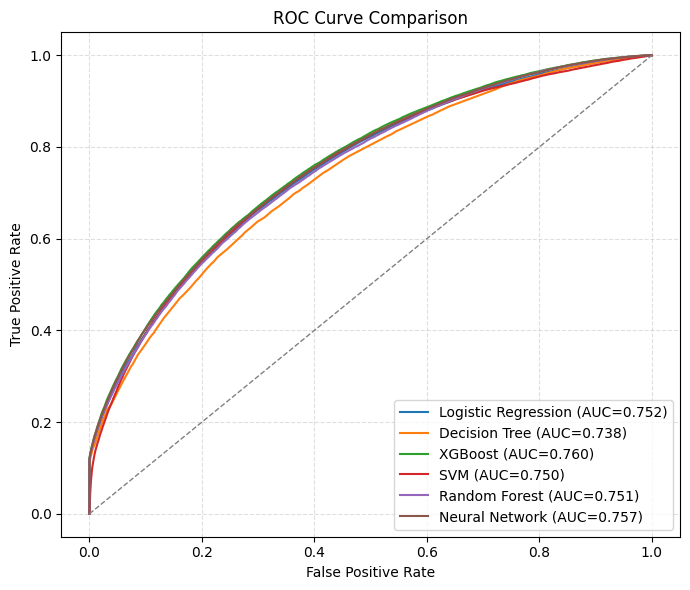

In [70]:
models = [
    "Logistic Regression",
    "Decision Tree",
    "XGBoost",
    "SVM",
    "Random Forest",
    "Neural Network"
]

plot_roc_comparison(models, out_dir="results")

